# ResNet

In [49]:
!pip install rdkit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 25.7 MB/s eta 0:00:00


In [50]:
import pandas as pd
import numpy as np
from scipy import stats
import os

import seaborn as sns
from matplotlib import pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch.nn import functional as F

from torchvision import datasets, models, transforms

from tqdm.notebook import tqdm

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
for i in tqdm(range(df_filtered.shape[0])):
    smiles = df_filtered.iloc[i]['SMILES']
    label = df_filtered.iloc[i]['Interval']
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    img.save(f"/content/drive/MyDrive/MISIS/ML_misis_6sem/ml_project/draw/{label}/{i}.png")


In [7]:
if not os.path.isdir('/content/drive/MyDrive/MISIS/ML_misis_6sem/ml_project/draw/'):
    os.mkdir('/content/drive/MyDrive/MISIS/ML_misis_6sem/ml_project/draw/')

for i in range(4):
    name = f"/content/drive/MyDrive/MISIS/ML_misis_6sem/ml_project/draw/{i}"
    if not os.path.isdir(name):
         os.mkdir(name)

In [55]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [56]:
image_dataset = datasets.ImageFolder('/content/drive/MyDrive/MISIS/ML_misis_6sem/ml_project/draw', transform=data_transforms)

In [57]:
targets = image_dataset.targets

train_idx, valid_idx, _, _ = train_test_split(
    range(len(targets)), targets, test_size=0.2, random_state=42, stratify=targets)

train_dataset = torch.utils.data.Subset(image_dataset, train_idx)
valid_dataset = torch.utils.data.Subset(image_dataset, valid_idx)

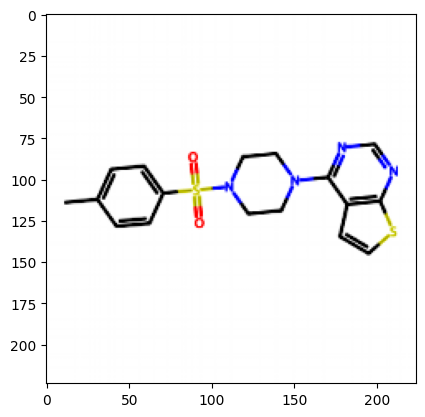

In [58]:
plt.imshow(train_dataset[0][0].numpy().transpose((1, 2, 0)))

In [59]:
BATCH_SIZE = 1028

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

In [60]:
def train(model, loaders, criterion, optimizer, scheduler, epochs=100):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    metrics = {"train": [], "valid": []}
    losses = {"train": [], "valid": []}
    # model.to(device)
    for epoch in tqdm(range(epochs), desc='epoch'):
        print(f"Epoch: {epoch+1}")

        for k, dataloader in loaders.items():
            loss_batch = []
            run_loss, run_metric, all, count = 0, 0, 0, 0

            for x_batch, y_batch in tqdm(dataloader):
                x_batch = x_batch.to(device)
                y_batch = y_batch.long().to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    loss_batch.append(loss.item())
                    optimizer.step()

                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)
                        loss_batch.append(loss.item())

                if k == "train":
                    scheduler.step()

                run_loss += loss.item()
                run_metric += (outp.argmax(1) == y_batch).sum().item()
                all += y_batch.shape[0]
                count += 1

            epoch_loss = run_loss / count
            epoch_metric = run_metric / all

            metrics[k].append(epoch_metric)
            losses[k].append(epoch_loss)

            print(f"Loader: {k:<10}Accuracy: {epoch_metric:<20}Loss: {epoch_loss:<20}")

    return metrics, losses

In [61]:
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 4),
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loaders = {"train": train_dataloader, 'valid': valid_dataloader}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
device

device(type='cuda')

In [63]:
metrics, losses = train(model, loaders, criterion, optimizer, scheduler, 10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: 